# 生成初始状态

In [1]:
import random
import time
import math
f = open("eightQueensTest.txt", "w")
testCaseCount = 200
board = ""
while testCaseCount > 0:
    testCaseCount -= 1
    for col in range(0,7):
        board += str(random.randint(0,7)) + ' '
    board += str(random.randint(0,7)) + '\n'
f.write(board)
f.close()

计算启发式代价

In [2]:
def getCollisionNum(board):
    num = 0
    for col in range(len(board)):
        for anotherCol in range(col+1, len(board)):
            if board[col] == board[anotherCol]:
                num += 1 # collied in the same row
            elif abs(board[col] - board[anotherCol]) == (anotherCol - col):
                num += 1 # collied diagonally
    return num

# 求解方法

## 最陡爬山
移动到启发式代价最小的位置

In [3]:
def step_steepestHillClimbing(board):
    collisionNumBoard = {}  # 字典，存储各个位置的代价
    smallestCollisionNum = getCollisionNum(board) - 1  # 改成 getCollisionNum(board) - 1 即可寻找更优解
    for col in range(len(board)):
        for row in range(len(board)):
            if board[col] == row:  # 每列的其他行
                continue
            originRow = board[col]  # 原来的行数
            board[col] = row  # 移位后的状态
            collisionNumBoard[(row, col)] = getCollisionNum(board)
            board[col] = originRow
        
    for point, value in collisionNumBoard.items():  # 找到最小代价
        if value < smallestCollisionNum:
            smallestCollisionNum = value

    smallestCollisionPoints = []
    for point, value in collisionNumBoard.items(): # 找出对应位置
        if value == smallestCollisionNum:
            smallestCollisionPoints.append(point)

    # 找不到更小或相同的代价
    if len(smallestCollisionPoints) == 0:
        global FAILED
        FAILED = True
        return board

    # 随机取代价最小的位置
    random.shuffle(smallestCollisionPoints)  
    board[smallestCollisionPoints[0][1]] = smallestCollisionPoints[0][0]
    return board


def solution_steepestHillClimbing(board):
    global FAILED
    maxRound = 200  # 代价相同，至多迭代100次，防止死循环
    count = 0
    while True:
        collisionNum = getCollisionNum(board)
        if collisionNum == 0:
            return board
        board = step_steepestHillClimbing(board)
        count += 1
        if FAILED:
            return board
        if (count >= maxRound):
            
            FAILED = True
            return board

## 首选爬山
随机生成下一个状态，只要不变好就转移

In [4]:
def step_FirstChoiceHillClimbing(board):
    collisionNum = getCollisionNum(board)
    maxRound = 500 # the expected number to find a better choice
    count = 0
    while True:
        count += 1
        if(count >= maxRound):
            global FAILED
            FAILED = True
            return board
        randomRow = random.randint(0,len(board)-1)
        randomCol = random.randint(0,len(board)-1)
        if board[randomCol] == randomRow:
            continue
        originRow = board[randomCol]
        board[randomCol] = randomRow
        if getCollisionNum(board) < collisionNum: # not worse than 如果要找到更好，改成 <
            return board
        board[randomCol] = originRow
        

def solution_FirstChoiceHillClimbing(board):
    maxRound = 200 # the expected number to find a solution
    count = 0
    while True:
        collisionNum = getCollisionNum(board)
        if collisionNum == 0:
            return board
        board = step_FirstChoiceHillClimbing(board)
        global FAILED
        if FAILED:
            return board
        count += 1
        if(count >= maxRound):
            FAILED = True
            return board

## 随机重启爬山
使用最陡爬山法，若找不到解，就生成一组新的初始状态。采用递归实现，递归结束条件：重启超过50轮，或者达到目标状态。

In [5]:
global restart_cnt
restart_cnt = 0
def solution_RandomHillClimbing(board):
    global restart_cnt
    global FAILED
    if restart_cnt > 50:  # 最多重启50轮
        FAILED = True
        return board
    board = solution_steepestHillClimbing(board)
    if FAILED:  # 失败则重启
        FAILED = False  # 一定要重置 FAILED 标志！
        restart_cnt += 1
        for col in range(0,7):
            board[col] = random.randint(0,7)
        # 再次搜索（递归）
        board = solution_RandomHillClimbing(board)
    return board

## 模拟退火
以概率$e^{-\frac{\Delta E}{T}}$ 接受更差的状态。
温度越低，接受更差状态的概率越小。

In [6]:
def solution_SimulatedAnnealing(board):
    temperature = 10  # 初温
    annealingRate = 0.80  # 降温速度
    stop_temprature = 0.0002  # temperature * annealingRate ** 50  # 停止温度
    maxRound = 100  # 每个温度循环次数
    
    while temperature > stop_temprature:
        for i in range(maxRound):
            randomRow = random.randint(0,len(board)-1)
            randomCol = random.randint(0,len(board)-1)
            if board[randomCol] == randomRow:
                continue
            originCollisionNum = getCollisionNum(board)
            originRow = board[randomCol]
            board[randomCol] = randomRow
            newCollisionNum = getCollisionNum(board)
            if newCollisionNum == 0:
                return board
           # 如果更差了，以一定概率拒绝
            if newCollisionNum > originCollisionNum:  
                if random.random() > math.exp(-(newCollisionNum - originCollisionNum) / temperature):  
                    board[randomCol] = originRow
                    
        temperature = temperature * annealingRate
    global FAILED
    FAILED = True
    return board

# 求解结果

In [7]:
def test(method):
    startTime = time.perf_counter()
    successCase = 0
    totalCase = 0
    result = "EightQueens" + method + " result:\n\n"
    with open("eightQueensTest.txt", "r") as ins:
        for line in ins:
            global FAILED
            FAILED = False
            global restart_cnt
            restart_cnt = 0
            totalCase += 1
            board = []
            for col in line.split():
                board.append(int(col))
            if method == 'SteepestHillClimbing':
                board = solution_steepestHillClimbing(board)
            elif method == 'FirstChoiceHillClimbing':
                board = solution_FirstChoiceHillClimbing(board)
            elif method == 'RandomHillClimbing':
                board = solution_RandomHillClimbing(board)
            else:
                board = solution_SimulatedAnnealing(board)
            if FAILED:
                result += "Failed!"
            else:
                successCase += 1
                for col in range(len(board)):
                    result += str(board[col]) + " "
            result += "\n"

        endTime = time.perf_counter()
        performance = "EightQueens-" + method +':\n'
        performance += "Total time: " + str(endTime - startTime) + '\n'
        performance += "Total case number: " + str(totalCase) + ", Success case number: " + str(successCase) + '\n'
        performance += "Success rate: " + str(successCase / float(totalCase)) + '\n'
        f = open('EightQueens_ '+method+ '.txt', 'w')
        f.write(result)
        f.write(performance)
        f.close()
        print(performance)
        return[endTime - startTime, successCase / float(totalCase)]

测试

In [8]:
[t1, a1] = test('SteepestHillClimbing')
[t2, a2] = test('FirstChoiceHillClimbing')
[t3, a3] = test('RandomHillClimbing')
[t4, a4] = test('SimulatedAnnealing')

EightQueens-SteepestHillClimbing:
Total time: 0.6628098000000007
Total case number: 200, Success case number: 31
Success rate: 0.155

EightQueens-FirstChoiceHillClimbing:
Total time: 1.6056638999999997
Total case number: 200, Success case number: 29
Success rate: 0.145

EightQueens-RandomHillClimbing:
Total time: 4.1095761
Total case number: 200, Success case number: 200
Success rate: 1.0

EightQueens-SimulatedAnnealing:
Total time: 6.677182800000001
Total case number: 200, Success case number: 197
Success rate: 0.985



## 不同方法性能比较
- 最陡爬升法求出解的理论概率为0.14
- 随机重启法比最陡爬升法的时间多了七倍
- 在计算时间足够长的情况下，随机重启法以概率1得到最优解
- 模拟退火算法用时最长，不一定能得到最优解

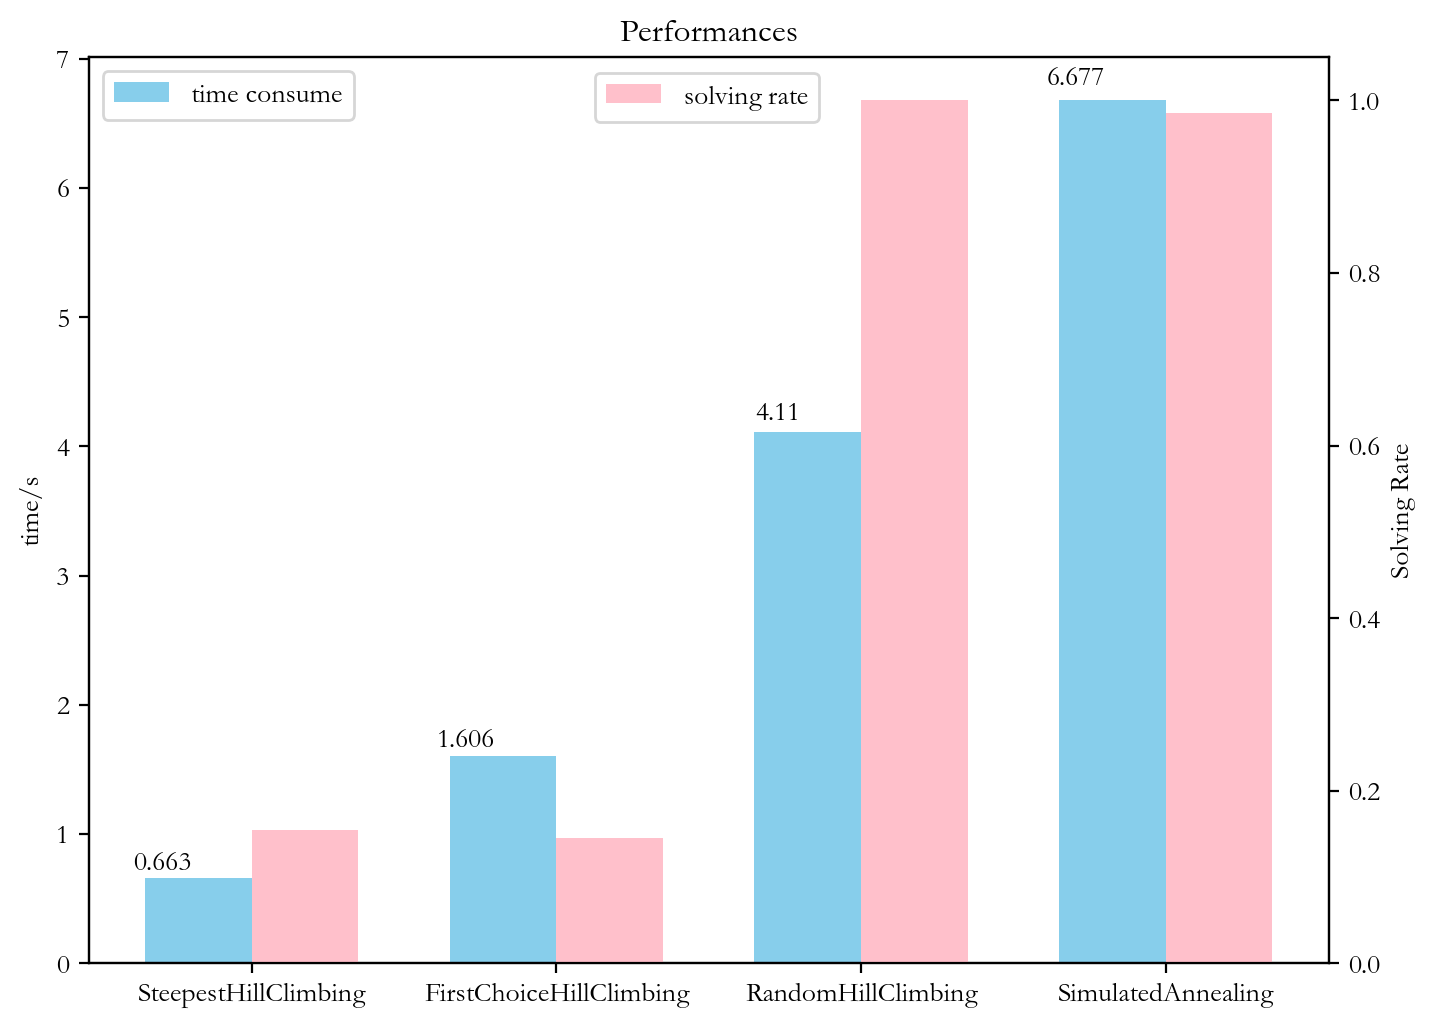

In [9]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib
matplotlib.rcParams['font.family'] = 'STSong'
matplotlib.rcParams['font.size'] = 10
plt.rcParams['figure.dpi'] = 200
t = np.array((round(t1,3), round(t2,3), round(t3,3), round(t4,3)))
s = np.array((round(a1,3), round(a2,3), round(a3,3), round(a4,3)))

ind = np.arange(len(t))  # the x locations for the groups
width = 0.35  # the width of the bars

fig, ax = plt.subplots(figsize=(8,6))
rects1 = ax.bar(ind - width/2, t, width, color='SkyBlue', label = 'time consume')
par2 = ax.twinx()
rects2 = par2.bar(ind + width/2, s, width, color='Pink', label = 'solving rate')


# Add some text for labels, title and custom x-axis tick labels, etc.
ax.set_ylabel('time/s')
ax.set_title('Performances')
ax.set_xticks(ind)
ax.set_xticklabels(('SteepestHillClimbing', 'FirstChoiceHillClimbing', 'RandomHillClimbing', 'SimulatedAnnealing'))
ax.legend()
par2.set_ylabel('Solving Rate')
par2.legend(bbox_to_anchor=(0.6,0.998))
def autolabel(rects, xpos='center'):
    """
    Attach a text label above each bar in *rects*, displaying its height.

    *xpos* indicates which side to place the text w.r.t. the center of
    the bar. It can be one of the following {'center', 'right', 'left'}.
    """

    xpos = xpos.lower()  # normalize the case of the parameter
    ha = {'center': 'center', 'right': 'left', 'left': 'right'}
    offset = {'center': 0.5, 'right': 0.57, 'left': 0.43}  # x_txt = x + w*off

    for rect in rects:
        height = rect.get_height()
        ax.text(rect.get_x() + rect.get_width()*offset[xpos], 1.01*height,
                '{}'.format(height), ha=ha[xpos], va='bottom')
        
autolabel(rects1, "left")

plt.show()

## 模拟退火超参数探究
控制变量，比较超参数的作用

|maxRound|$\alpha$|求解时间|解决率|
|---|---|---|---|
|100|0.95| 23.8|0.995 |
|100|0.90| 14.9|0.995 |
|100|0.80| 9.8|0.965| 
|20|0.80|7.4|0.91|
|500|0.80|27.9 |1.0 |